In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import gc
import csv
import seaborn as sns
import matplotlib.cm as cm
from scipy.interpolate import griddata

gc.enable()

In [2]:
# To make things easier, convert to csv. 
# This specifi .dat file is a mess, looses data when opening up as a .dat...

datContent = [i.strip().split() for i in open("./data/AllStations_temperature_h_2019.dat").readlines()]
with open("./data/AllStations_temperature_h_2019.csv", "wt") as f: 
    writer = csv.writer(f)
    writer.writerows(datContent)

### Importing the data and preparing it so that it can be used for analysis

In [2]:
# Import the data
hour_data_file = './data/AllStations_temperature_h_2019.csv'
hour_data = pd.read_csv(hour_data_file, header=None)

# Rename columns to show the weather station name
hour_data.rename(columns={0: "Timestamp",1:"Brentwood", 2:"CalRevelle", 4:"Colquitz", 3:"CampusView", 5:"Colwood",
6:"CordovaBay", 7:"CrystalView", 8:"DeepCove", 9:"Doncaster", 10:"EdwardMilne", 11:"Esquimalt", 12:"FrancesKelsey",
13:"FrankHobbs", 14:"HappyValley", 15:"Helgesen",16:"JamesBay", 17:"JohnMuir", 18:"Journey", 19:"Keating",20:"Kelset",
21:"LakeHill",22:"Lakewood",24:"Lochside", 23:"Lansdown",25:"Macaulay", 26:"MargaretJenkins",
27:"Monterey", 28:"Parkland",29:"Quadra",30:"Reynolds",31:"Rogers",32:"Sangster",33:"ShawniganSchool",
34:"Shoreline",35:"Sidney",36:"Torquay", 37:"UVicSci",38:"Willows",39:"Willway"},inplace=True)

# The timestamps in the data sets are given in Matlab's Datenum format, so must convert it to datetime format.
offset = datetime(1970, 1, 1).toordinal() + 366
good_timestamp = pd.to_datetime(hour_data['Timestamp'] - offset, unit='D')
hour_data['Timestamp'] = good_timestamp
hour_data.set_index('Timestamp', drop=True, inplace=True)

#check the type of index 
hour_data.index.inferred_type == "datetime64"
# Peak at the dataframe to see if there is any big errors

hour_data
# just under 3 million data point...


Brentwood  CalRevelle  CampusView  Colquitz  \
Timestamp                                                              
NaT                       236.5540    236.4990    236.6790  236.6070   
NaT                        48.5745     48.5376     48.4655   48.4608   
2008-01-01 00:00:00.000     3.2500      1.4300      4.2100    4.6200   
2008-01-01 01:00:02.880     3.0600      1.3800      4.2800    4.7700   
2008-01-01 01:59:57.120     1.9000      1.1800      4.1200    4.7000   
...                            ...         ...         ...       ...   
2019-08-30 19:59:57.120    20.3100     17.7500     19.7700   19.8400   
2019-08-30 21:00:00.000    19.1400     16.4400     19.1700   19.3800   
2019-08-30 22:00:02.880    18.4900     16.0700     17.5900   18.6900   
2019-08-30 22:59:57.120    17.2200     16.1200     16.1400   17.3700   
2019-08-31 00:00:00.000    16.6200     15.9000     15.9300   16.6400   

                          Colwood  CordovaBay  CrystalView  DeepCove  \
Timestamp                                                              
NaT                      236.5140    236.6300     236.5230  236.5430   
NaT                       48.4356     48.5273      48.4529   48.6804   
2008-01-01 00:00:00.000    3.4500      4.4400       2.7200    3.9700   
2008-01-01 01:00:02.880    3.4600      4.2100       2.6400    4.1500   
2008-01-01 01:59:57.120    3.4600      4.0700       2.6400    4.1800   
...                           ...         ...          ...       ...   
2019-08-30 19:59:57.120   19.6500     18.4900      18.9900   18.7900   
2019-08-30 21:00:00.000   19.2200     16.8400      18.2900   18.2300   
2019-08-30 22:00:02.880   19.1300     15.0200      18.3200   18.3700   
2019-08-30 22:59:57.120   17.4500     14.1300      17.4400   17.9900   
2019-08-31 00:00:00.000   16.4700     15.1100      16.4400   16.9500   

                         Doncaster  EdwardMilne  ...  Reynolds    Rogers  \
Timestamp                                        ...                       
NaT                       236.6620     236.3040  ...  236.6410  236.6190   
NaT                        48.4562      48.3891  ...   48.4683   48.4744   
2008-01-01 00:00:00.000     4.6800       5.1200  ...    4.2900    4.1000   
2008-01-01 01:00:02.880     4.6100       4.9500  ...    4.4100    4.3000   
2008-01-01 01:59:57.120     4.6200       5.1100  ...    4.2400    4.2300   
...                            ...          ...  ...       ...       ...   
2019-08-30 19:59:57.120    19.5800      18.9300  ...   20.3400   19.8300   
2019-08-30 21:00:00.000    18.9100      17.7000  ...   19.7300   19.2300   
2019-08-30 22:00:02.880    17.8500      14.9800  ...   18.6300   18.4200   
2019-08-30 22:59:57.120    16.5300      15.1300  ...   17.1000   16.7700   
2019-08-31 00:00:00.000    16.6900      15.3500  ...   16.3000   16.3000   

                         Sangster  ShawniganSchool  Shoreline    Sidney  \
Timestamp                                                                 
NaT                      236.5140         236.3570   236.5740  236.5960   
NaT                       48.4205          48.6568    48.4533   48.6529   
2008-01-01 00:00:00.000    3.0100              NaN     4.0000    4.8100   
2008-01-01 01:00:02.880    2.8700              NaN     4.1500    4.6000   
2008-01-01 01:59:57.120    2.9700              NaN     4.0600    4.6500   
...                           ...              ...        ...       ...   
2019-08-30 19:59:57.120   19.8600              NaN        NaN   17.3100   
2019-08-30 21:00:00.000   19.5100              NaN        NaN   16.9300   
2019-08-30 22:00:02.880   19.4200              NaN        NaN   17.1500   
2019-08-30 22:59:57.120   17.5700              NaN        NaN   15.4000   
2019-08-31 00:00:00.000   16.6700              NaN        NaN   15.2200   

                          Torquay   UVicSci   Willows   Willway  
Timestamp                                                        
NaT                      236.6760  236.6910  236.6890 

In [3]:
# First 2 rows of dataframe are coordinates of stations. Save them in dictionary and remove from dataframe

station_coord = {} # (lon, lat) format
for stn in hour_data.columns:
    station_coord[stn] = (hour_data[stn].iloc[0], hour_data[stn].iloc[1])


In [4]:
station_coord

{'Brentwood': (236.554, 48.5745),
 'CalRevelle': (236.499, 48.5376),
 'CampusView': (236.679, 48.4655),
 'Colquitz': (236.607, 48.4608),
 'Colwood': (236.514, 48.4356),
 'CordovaBay': (236.63, 48.5273),
 'CrystalView': (236.523, 48.4529),
 'DeepCove': (236.543, 48.6804),
 'Doncaster': (236.662, 48.4562),
 'EdwardMilne': (236.304, 48.3891),
 'Esquimalt': (236.604, 48.4382),
 'FrancesKelsey': (236.43, 48.66),
 'FrankHobbs': (236.7, 48.4651),
 'HappyValley': (236.471, 48.4281),
 'Helgesen': (236.446, 48.364),
 'JamesBay': (236.62, 48.4169),
 'JohnMuir': (236.25, 48.371),
 'Journey': (236.283, 48.3874),
 'Keating': (236.597, 48.5677),
 'Kelset': (236.577, 48.6258),
 'LakeHill': (236.635, 48.4788),
 'Lakewood': (236.494, 48.4655),
 'Lansdown': (236.672, 48.4451),
 'Lochside': (236.639, 48.5014),
 'Macaulay': (236.595, 48.4253),
 'MargaretJenkins': (236.67, 48.4161),
 'Monterey': (236.686, 48.4182),
 'Parkland': (236.579, 48.6701),
 'Quadra': (236.639, 48.4456),
 'Reynolds': (236.641, 48.468

In [4]:
# remove coordinates from weather data
hour_data = hour_data.iloc[2:]

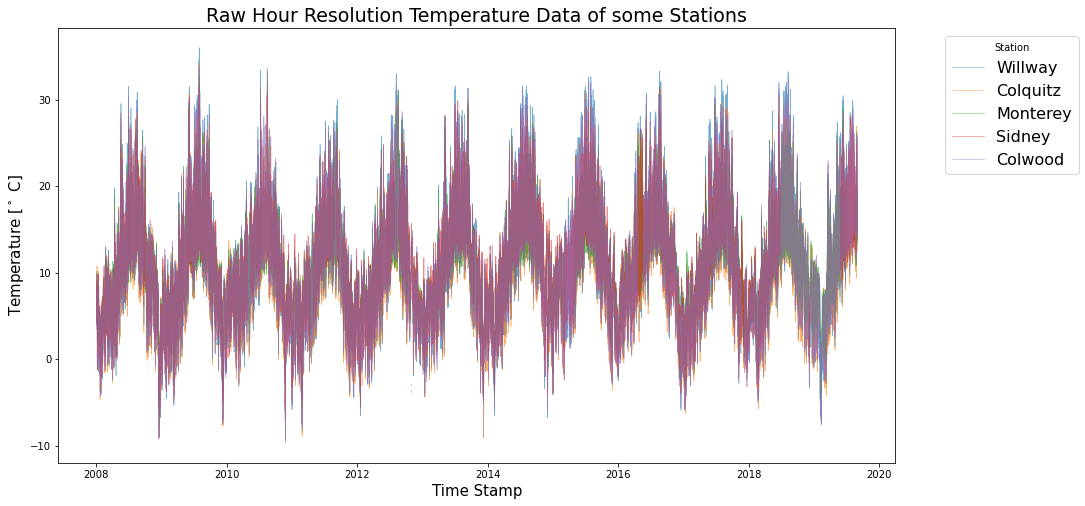

In [5]:
# plot the data from some stations picked at random to check for inconsistencies in the data

#pick stations at random
import random

number_of_stns = 5
rndm_stns = np.random.choice(hour_data.columns, number_of_stns)

plt.close(1);plt.figure(1, figsize=(15,8))
[plt.plot(hour_data[stn][2:], linewidth=0.6, label=stn, alpha=0.6) for stn in rndm_stns]

plt.xlabel('Time Stamp',fontsize=15)
plt.ylabel('Temperature [${^\circ}$ C]',fontsize=15)
plt.title('Raw Hour Resolution Temperature Data of some Stations',fontsize=19)
plt.legend(title='Station', prop={'size': 16}, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.style.use('ggplot')
plt.savefig('./Images/Hour_data_rndm_stns.png')
plt.show()

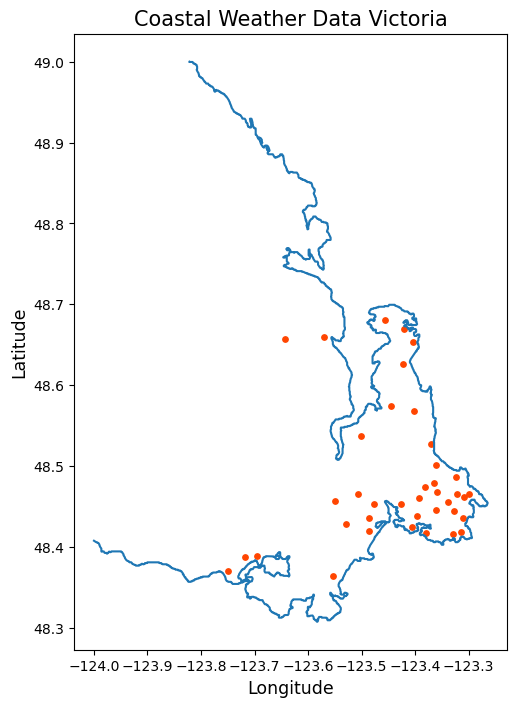

In [7]:
# Plot location of stations on map

# Load data in lists
coast = np.loadtxt('./Data/Coast.dat')
coast_lon = []
coast_lat = []
for i in range(0,len(coast)):
    coast_lon.append(coast[i][0])
    coast_lat.append(coast[i][1])

# Project the data to make the map
mid = coast_lat[int(len(coast)/2)]
rad = (mid * np.pi) / 180
ratio = np.cos(rad)
inverse = 1/ratio


station_lon = []
station_lat = []

for stn in station_coord:
    station_lon.append(station_coord[stn][0])
    station_lat.append(station_coord[stn][1])
    
# recale longitude
for i in range(0,len(station_lon)):
    station_lon[i] = -180 + (station_lon[i] - 180)

nums = np.arange(1,40,1)

plt.close(2);plt.figure(2,figsize=(8,8), facecolor='white') #fig size same as before
ax = plt.gca() #you first need to get the axis handle
ax.set_aspect(inverse) #sets the height to width ratio to 1.5. 
"""
for i in range(len(nums)):
    ax.annotate(nums[i], (station_lon[i]-0.04, station_lat[i]+0.005), fontsize=7)
"""
plt.plot(coast_lon,coast_lat)
plt.scatter(station_lon,station_lat,color='orangered',s=15)
plt.title('Coastal Weather Data Victoria',fontsize=15)
plt.xlabel('Longitude',fontsize=12.5)
plt.ylabel('Latitude',fontsize=12.5)
plt.savefig("./Images/CoastWithStations.png")
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()
plt.style.use('default')
plt.show()

To move forward with the analysis, we need to make sure there are no NaN values in our data set 

In [9]:
hour_data.isna().sum()

Brentwood          12443
CalRevelle          3729
CampusView          2571
Colquitz            2667
Colwood             2246
CordovaBay          4099
CrystalView         5655
DeepCove            3136
Doncaster          10144
EdwardMilne         6308
Esquimalt           1069
FrancesKelsey       6093
FrankHobbs          2718
HappyValley         2470
Helgesen            5100
JamesBay            4168
JohnMuir           11359
Journey             8775
Keating            11447
Kelset             32977
LakeHill            2088
Lakewood            5405
Lansdown            2791
Lochside            5915
Macaulay            2718
MargaretJenkins    17719
Monterey            4202
Parkland            8817
Quadra             14294
Reynolds            3429
Rogers              6283
Sangster            5727
ShawniganSchool    25229
Shoreline           4684
Sidney             11975
Torquay             5102
UVicSci            12731
Willows            19982
Willway             7347
dtype: int64

We see that there are a lot of NaN values. This is due to each station starting/ending their recording of data at different times, and some stations may have had a break in data collection at times.<br><br>
We will interpolate the missing values.

In [8]:
# Interp missing vals
hour_data.interpolate(method='time',limit_direction='both',inplace=True)
hour_data.isna().sum()

<ipython-input-8-c6e8bd9cce67>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hour_data.interpolate(method='time',limit_direction='both',inplace=True)


Brentwood          0
CalRevelle         0
CampusView         0
Colquitz           0
Colwood            0
CordovaBay         0
CrystalView        0
DeepCove           0
Doncaster          0
EdwardMilne        0
Esquimalt          0
FrancesKelsey      0
FrankHobbs         0
HappyValley        0
Helgesen           0
JamesBay           0
JohnMuir           0
Journey            0
Keating            0
Kelset             0
LakeHill           0
Lakewood           0
Lansdown           0
Lochside           0
Macaulay           0
MargaretJenkins    0
Monterey           0
Parkland           0
Quadra             0
Reynolds           0
Rogers             0
Sangster           0
ShawniganSchool    0
Shoreline          0
Sidney             0
Torquay            0
UVicSci            0
Willows            0
Willway            0
dtype: int64

The end goal of the pca analysis is to find the principal node components of varience of our data set. Using those we want to visualize spatial-temporal weather patterns. <br><br>
Before proceeding we will do a "test run" to interpolate the data to a grid of the Greater Victoria peninsula.

In [9]:
#Get 4 time slices => one each season
Summer = hour_data.loc['2016-06-26 00:00:00']
Winter = hour_data.loc['2016-12-24 00:00:00']
Spring = hour_data.loc['2016-04-10 00:00:00']
Autumn = hour_data.loc['2016-10-31 00:00:00']
xi = np.linspace(x_min,x_max, 5000)
yi = np.linspace(y_min,y_max, 5000)
Xi, Yi= np.meshgrid(xi,yi)

extent = [x_min, x_max, y_min, y_max]

In [22]:
grid_Summer = griddata((station_lon, station_lat), Summer.values[0], (Xi, Yi), method='nearest')
grid_Winter = griddata((station_lon, station_lat), Winter.values[0], (Xi, Yi), method='nearest')
grid_Spring = griddata((station_lon, station_lat), Spring.values[0], (Xi, Yi), method='nearest')
grid_Autumn = griddata((station_lon, station_lat), Autumn.values[0], (Xi, Yi), method='nearest')

grid_Season = [grid_Summer, grid_Winter, grid_Spring, grid_Autumn]
Seasons     = ['Summer', 'Winter', 'Spinrg', 'Autumn']

(1, 39)

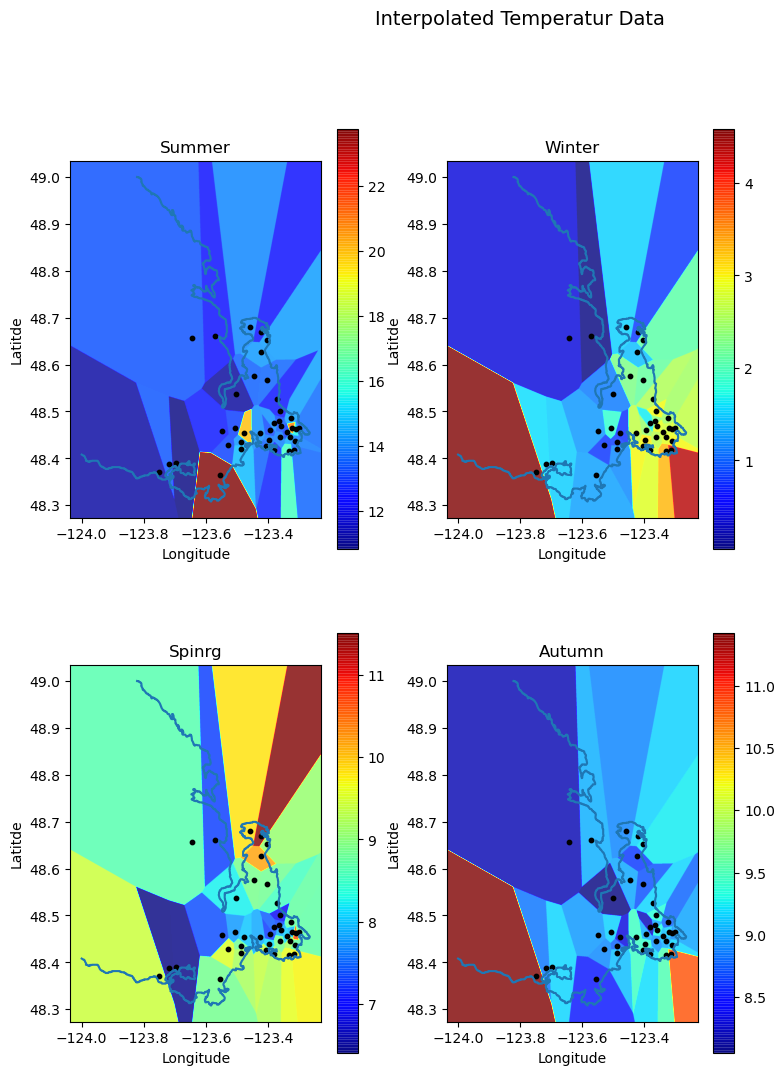

In [24]:

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,12))

for ax, i in zip(axes.flat, range(len(Seasons))):
    im = ax.imshow(grid_Season[i],origin='lower',extent=extent, cmap='jet',alpha=0.8)
    ax.plot(coast_lon,coast_lat)
    ax.scatter(station_lon, station_lat, s = 10,color='black')
    ax.set_aspect(inverse)
    ax.set_title(Seasons[i])
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitde')
    plt.colorbar(im,ax = ax)
fig.subplots_adjust(right=0.7)
# put colorbar at desire position
fig.suptitle('Interpolated Temperatur Data', fontsize = 14)
plt.savefig('./Images/InterpTempOnMap.png')
plt.show()

In [29]:
plt.close(fig)

Start PCA analysis
-------------------

Idea:
- look at the correlation matrix between stations
- find eigen val/vects of matrix ^
- look at which eigen vect explains the most variance
- Use that info to find the PCA with the appropriate number of components
- Consider the components of the PCA as weights
- apply the weights to each corresponding station (project the data onto the components)
- last step will create a time series of the projection
- interpolate projections onto a grid of the region
- plot grid to look at weather patterns in the region

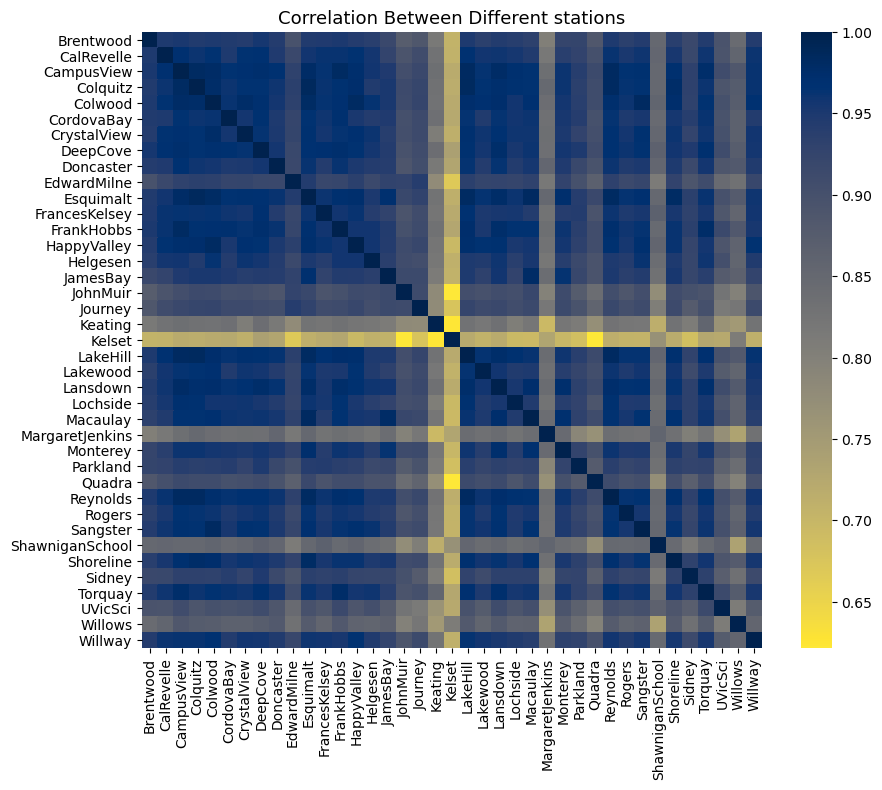

In [10]:
# Center the data 
hour_data_centered = (hour_data - hour_data.mean())
# create correlation matrix
corr = hour_data.corr()
plt.close(5);plt.figure(4, figsize=(10,8))
sns.heatmap(corr,cmap='cividis_r')
plt.title('Correlation Between Different stations', fontsize = 13)
plt.savefig("./Images/CrossCorr_HeatMap_HourData.png")

In [11]:
# will be using covariance matrix to find PCA
cov_matrix = np.cov(hour_data_centered.T)
eigen_vals, eigen_vects = np.linalg.eig(cov_matrix) # eigen_vects are normalized by default

# each eigen val = variance in the direction of the corresponding eigenvector. tot = the total variance explained
tot = sum(eigen_vals) 
variacne_explained = [(i/tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(variacne_explained)

# make sure each component (i.e. weather station) is included in the variance explained
assert len(variacne_explained) == 39 , " There should be 39 coponents contributing to the explained variance"

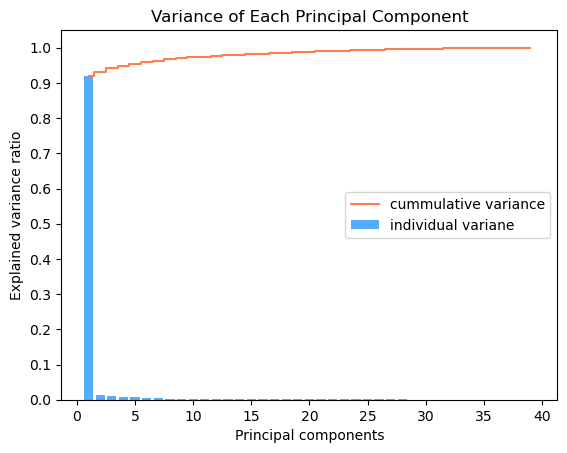

In [12]:
# Plot variance in each direction

plt.close(6);plt.figure(6)
yticktick = np.arange(0, 1.1, 0.1)

plt.bar(range(1,40), variacne_explained, alpha=0.75, align='center', label='individual variane', color='dodgerblue')
plt.step(range(1,40), cum_var_exp, where='mid', label='cummulative variance', color='coral')
plt.xlabel('Principal components')
plt.ylabel('Explained variance ratio')
plt.yticks(yticktick)
plt.legend(loc='center right')
plt.title('Variance of Each Principal Component')
plt.savefig('./Images/VariancePrincipleComponent.png')
plt.show()

The first component accounts for almost 92% of the observed variance in the data. While the second component is much much smaller (accounting for 0.01% of the variance), we will none the less include it in the analysis

In [13]:
# Feature Transformation
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vects[:,i]) for i in range(len(eigen_vals))]

# sort eigen vals
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

# create projection matrix W
# We will be using first 2 components
W = np.hstack((eigen_pairs[0][1][:,np.newaxis], eigen_pairs[1][1][:,np.newaxis]))

#We have 39 stations, and we have 2 principal comps, so expect W to have 39 rows and 2 cols
assert W.shape == (39, 2), "Porj matrix has wrong shape"

Now we we can reduce the dimensionality of our data set, and project the data on in the direction of the highest correlation

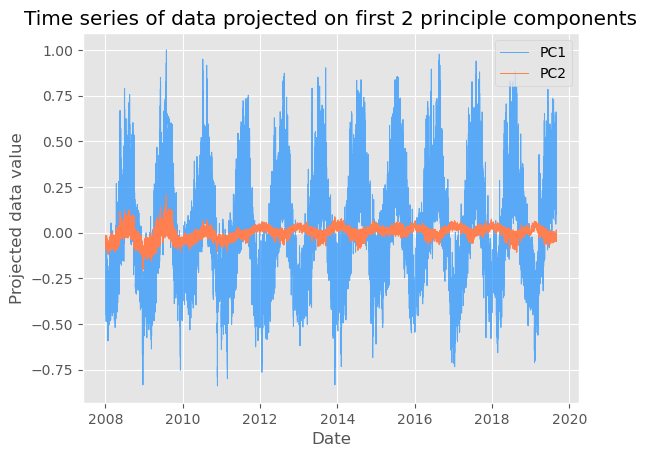

In [14]:
hour_data_proj = hour_data_centered.values.dot(W)

# Create a time series of the projected data
pdata = {'PC1':hour_data_proj.T[0], 'PC2':hour_data_proj.T[1]}
projected_data = pd.DataFrame(pdata, index=hour_data.index.copy())

# Plot the centered and normalized time series
norm_pc1 = (projected_data['PC1']-projected_data['PC1'].mean())/max(projected_data['PC1'])
norm_pc2 = (projected_data['PC2']-projected_data['PC2'].mean())/max(projected_data['PC1'])
plt.close(11);plt.figure(11)
plt.style.use('ggplot')
plt.plot(projected_data.index, norm_pc1, lw=0.7, color='dodgerblue', alpha= 0.7, label='PC1')
plt.plot(projected_data.index, norm_pc2, lw=0.7, color='coral', label='PC2')
plt.xlabel('Date')
plt.ylabel('Projected data value')
plt.title('Time series of data projected on first 2 principle components')
plt.legend()
plt.savefig('./Images/PC_time_series.png')
plt.show()

Now we can interpolate the projected data on a grid of the region which will visualize the weather patterns in the region. Do to so, we will use W, the projection matrix. The columns of W are the principal components, i.e., orthoganal basis vectors. The first column is the direction with the greatest variance, the second column is the direction with the greatest variance w.r.t the first component (first col of W). We can view these columns as "weights". There are 39 rows in each col, one for each station, so each entry corresponds to how much of the variance the corresponding station contributes. Said more simply, a high value in W corresponds to that station having a lot of variance in its data, compared to a station with lower entry in W. So Temperatures will fluctuate more in the region of the station with greater weights (in W) than those with lower weights.

In [15]:
grid_pc1 = griddata((station_lon, station_lat), np.abs(W.T[0]), (Xi, Yi))
grid_pc2 = griddata((station_lon, station_lat), np.abs(W.T[1]), (Xi, Yi))

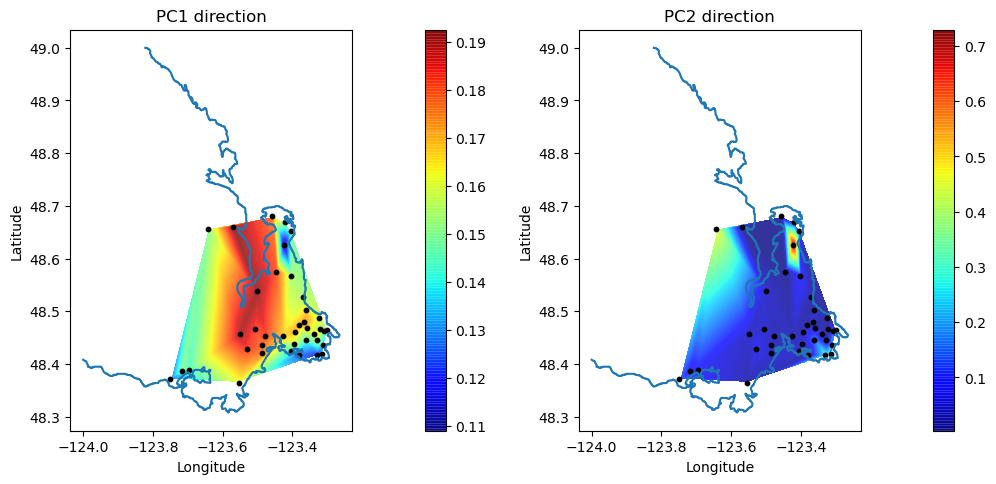

In [124]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
handle = ['Mode 1', 'Mode 2']
plt.close(fig) # clear it from memory before reloding
fig, ax = plt.subplots(nrows=1, ncols=3, figsize= (15,15))
plt.style.use('default')

impc1 = ax[0].imshow(grid_pc1,origin='lower',extent=extent, cmap='jet',alpha=0.8)
ax[0].plot(coast_lon,coast_lat)
ax[0].scatter(station_lon, station_lat, s = 10,color='black')
ax[0].set_aspect(inverse)
ax[0].set_title('PC1 direction')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')
divider1 = make_axes_locatable(ax[0])
cax1 = divider1.append_axes('right', size="5%", pad=0.001)
fig.colorbar(impc1, cax=cax1)

impc2 = ax[1].imshow(grid_pc2,origin='lower',extent=extent, cmap='jet',alpha=0.8)
ax[1].plot(coast_lon,coast_lat)
ax[1].scatter(station_lon, station_lat, s = 10,color='black')
ax[1].set_aspect(inverse)
ax[1].set_title('PC2 direction')
divider2 = make_axes_locatable(ax[1])
cax2 = divider2.append_axes('right', size="5%", pad=0.001)
fig.colorbar(impc2, cax=cax2)
fig.delaxes(ax[2])
ax[0].grid(False)
ax[1].grid(False)
plt.tight_layout()
plt.savefig('./Images/PCA_map.png')
plt.show()

 

griddate from scipy forms a convex hull from input. In our case the our input coordinates are the station coord which form the shape seen in the plots above. The rest of the map (outside this convex hull) are just nan. This is normal since griddata interpolates INSIDE the convex hull. 